# **Load Data**

In [1]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shutil
import os
import shutil
from tqdm import tqdm
import glob as gb

import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers, Model
from keras.models import Sequential, Model
from keras.layers import *

# **Data Exploration**

In [2]:
data = pd.read_csv("Data.csv")
print(data.head())
data

            Image   Label
0  597631776.jpeg  normal
1   35266064.jpeg   virus
2  467414642.jpeg  normal
3   35667640.jpeg  normal
4  618841263.jpeg  normal


Image   Label
0     597631776.jpeg  normal
1      35266064.jpeg   virus
2     467414642.jpeg  normal
3      35667640.jpeg  normal
4     618841263.jpeg  normal
...              ...     ...
1191  118777221.jpeg   virus
1192  375945707.jpeg  normal
1193  531745860.jpeg   virus
1194  121544623.jpeg   covid
1195  327147141.jpeg   virus

[1196 rows x 2 columns]

In [3]:
print(data['Label'])

0       normal
1        virus
2       normal
3       normal
4       normal
         ...  
1191     virus
1192    normal
1193     virus
1194     covid
1195     virus
Name: Label, Length: 1196, dtype: object


In [4]:
data["Label"].value_counts()

Label
normal    468
virus     433
covid     295
Name: count, dtype: int64

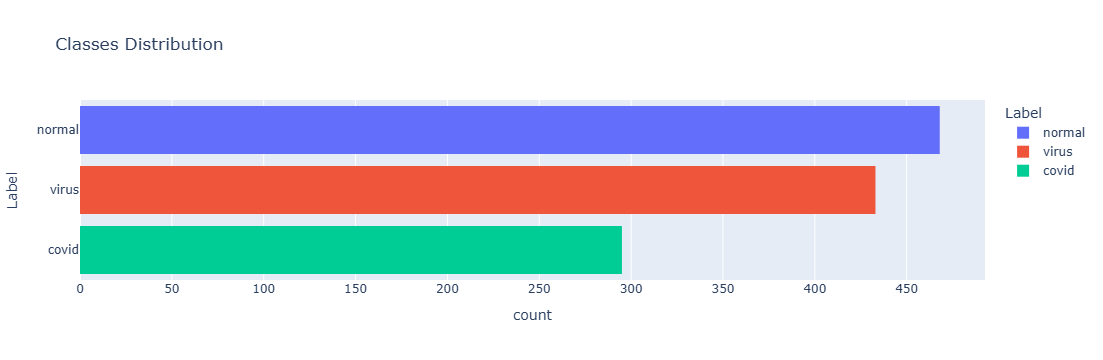

In [5]:
px.histogram(data, y="Label", color="Label", title="Classes Distribution")

* **Covid Class Being Less Present than others.**

In [6]:
Classes = ['covid', 'normal', 'virus']

In [7]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):

  """
  Plot a Random Image of Each Class in Train/Test Folder.
  """

  plt.figure(figsize = (25, 8))

  image_count = 1

  for directory in os.listdir(BASE_URL):

      if directory[0] != '.':

          Max_Random = len(os.listdir(os.path.join(BASE_URL,directory)))

          Random_Number = np.random.randint(0, Max_Random)

          for i, file in enumerate(os.listdir(BASE_URL + directory)):

              if i == Random_Number:

                  fig = plt.subplot(Rows, Columns, image_count)
                  image_count += 1

                  image = plt.imread(BASE_URL + directory + '/' + file)
                  plt.imshow(image)

                  plt.title(directory)

                  break

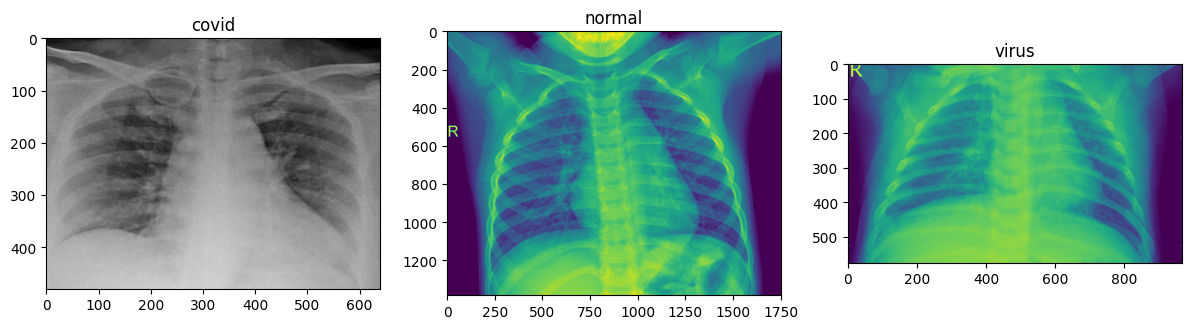

In [8]:
data_dir = "C:\\Users\\user\\Downloads\\CNN\\Data\\"
Plot_Classes("C:\\Users\\user\\Downloads\\CNN\\Data\\")

In [9]:
size = []
for folder in  os.listdir(data_dir) :
    files_je = gb.glob(pathname= str( data_dir + folder + '/*.jpeg'))
    files_jp = gb.glob(pathname= str( data_dir + folder + '/*.jpg'))
    files_pn = gb.glob(pathname= str( data_dir + folder + '/*.png'))
    files = files_je + files_jp + files_pn
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(480, 640, 3)      136
(480, 640)          16
(480, 640, 4)       12
(842, 1024, 3)       6
(1024, 1024, 3)      3
                  ... 
(885, 1292)          1
(1326, 1862)         1
(955, 1226)          1
(1383, 1808)         1
(696, 1008)          1
Name: count, Length: 1007, dtype: int64

(480, 640, 3)


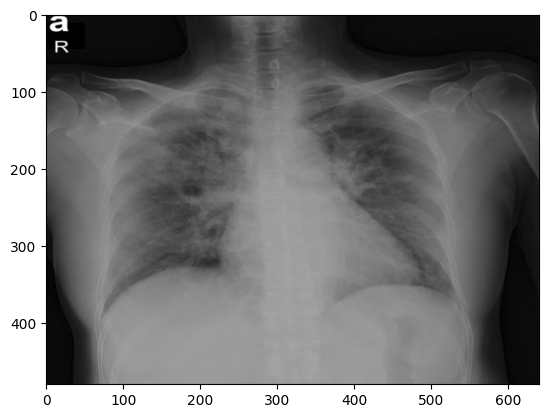

In [10]:
covidImg = plt.imread("C:\\Users\\user\\Downloads\\CNN\\Data\\covid\\100126173.png")
print(covidImg.shape)
plt.imshow(covidImg)

In [11]:
covidImg[0]

array([[0.05098039, 0.05098039, 0.05098039],
       [0.05098039, 0.05098039, 0.05098039],
       [0.04705882, 0.04705882, 0.04705882],
       ...,
       [0.04313726, 0.04313726, 0.04313726],
       [0.03529412, 0.03529412, 0.03529412],
       [0.10196079, 0.10196079, 0.10196079]], dtype=float32)

- **Notice that the Covid Class Images are Represented as RGB Array of Images and it's Float Type (normalized).**

(1264, 1762)


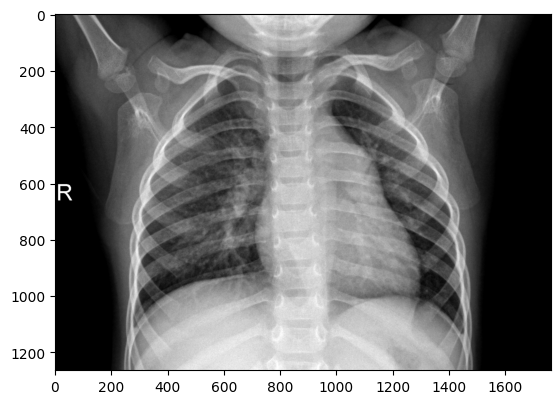

In [12]:
normalImg = plt.imread("C:\\Users\\user\\Downloads\\CNN\\Data\\normal\\101212332.jpeg")
print(normalImg.shape)
plt.imshow(normalImg, cmap='gray')

In [13]:
normalImg[normalImg!=0]

array([41, 41, 40, ...,  3,  2,  1], dtype=uint8)

(1592, 1880)


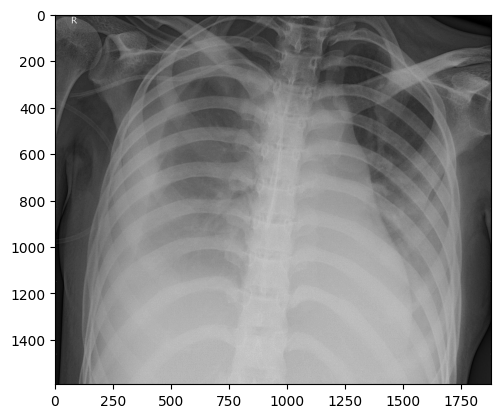

In [14]:
virusImg = plt.imread("C:\\Users\\user\\Downloads\\CNN\\Data\\virus\\10364395.jpeg")
print(virusImg.shape)
plt.imshow(virusImg, cmap='gray')

In [15]:
virusImg[virusImg!=0]

array([67, 68, 69, ..., 39, 32, 37], dtype=uint8)

- **Unlike the other two Classes being real gray scaled images with int Types(not normalized).**

# **Data Preprocessing**

In [16]:
for index, row in data.iterrows():

  path_to_img = data_dir + row['Label'] + '/' + row['Image']

  row['Image'] = path_to_img

In [17]:
data.head()

Image   Label
0  C:\Users\user\Downloads\CNN\Data\normal/597631...  normal
1  C:\Users\user\Downloads\CNN\Data\virus/3526606...   virus
2  C:\Users\user\Downloads\CNN\Data\normal/467414...  normal
3  C:\Users\user\Downloads\CNN\Data\normal/356676...  normal
4  C:\Users\user\Downloads\CNN\Data\normal/618841...  normal

- **Now Let's Split the Data to Train-Test Split that have the Same Class Distribution as Original Data.**

In [18]:
x = data.drop(columns="Label")
y = data["Label"]

In [19]:
# Validation Split
x_train, x_test, y_train, y_test = train_test_split( x , y , test_size=0.15, random_state=0 )

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1016, 1)
(1016,)
(180, 1)
(180,)


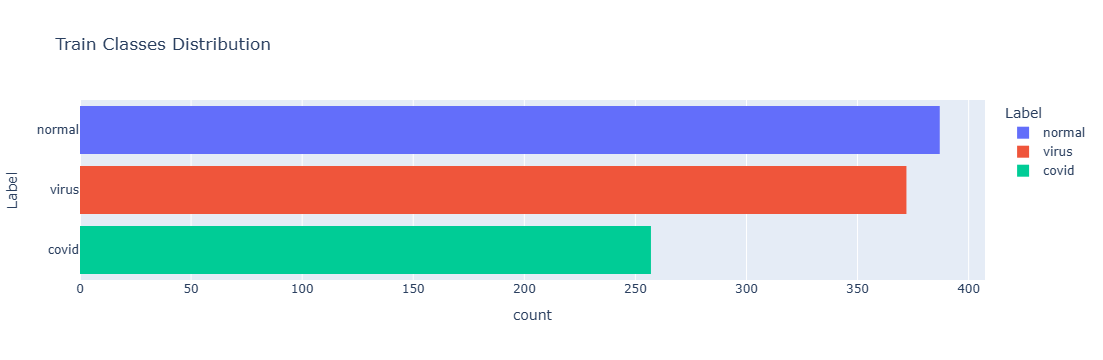

In [21]:
train_df = pd.concat([x_train,y_train], axis = 1)

px.histogram(train_df, y="Label", color="Label", title="Train Classes Distribution").update_yaxes(categoryorder='total ascending')

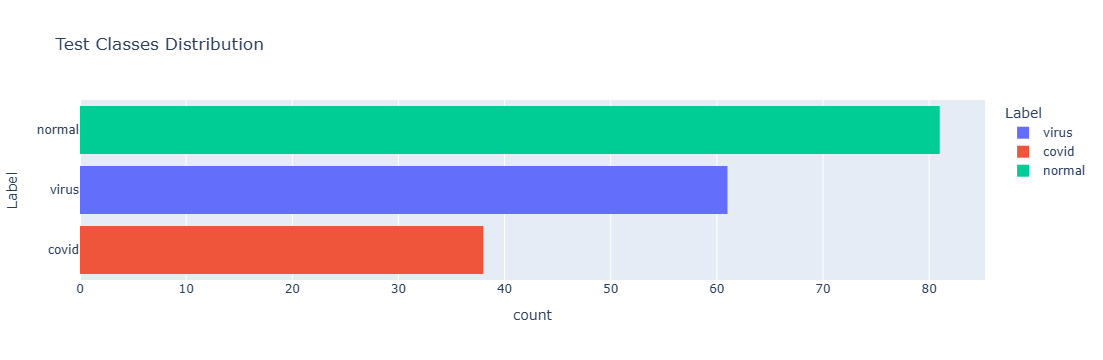

In [22]:
test_df = pd.concat([x_test,y_test], axis = 1)

px.histogram(test_df, y="Label", color="Label", title="Test Classes Distribution").update_yaxes(categoryorder='total ascending')

- **Notice how all the splits have the same classes distribution to the original data.**

## **Image Data Generators**




In [23]:
img_shape = 150

color_type = 3

batch_size = 32

In [24]:
train_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="Image",
    y_col="Label",
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    seed=0
)

test_data = test_preprocessor.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col="Image",
    y_col="Label",
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    seed=0
)

Found 1016 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


In [25]:
print("Number of Train batches:", len(train_data))
print("Number of Val batches:", len(test_data))

Number of Train batches: 32
Number of Val batches: 6


## **Checking Generators**

In [26]:
Classes_Map = train_data.class_indices

Num_Classes = len(Classes_Map)

print("Number of Classes:", Num_Classes)
Classes_Map

Number of Classes: 3


{'covid': 0, 'normal': 1, 'virus': 2}

In [27]:
train_data[0][0][0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02745098, 0.02745098, 0.02745098]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01960784, 0.01960784, 0.01960784]],

       ...,

       [[0.01176471, 0.01176471, 0.01176471],
        [0.        , 0.        , 0.        ],
        [0.        , 0

[1. 0. 0.]


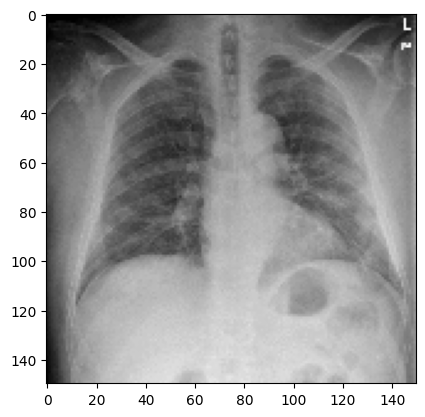

In [28]:
plt.imshow(train_data[0][0][-1])
print(train_data[0][1][-1])

In [29]:
test_data[1][0][-1]

array([[[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.03529412, 0.03529412, 0.03529412],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.05490196, 0.05490196, 0.05490196],
        [0.00784314, 0

[1. 0. 0.]


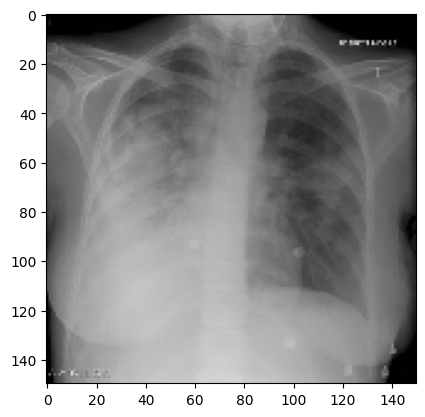

In [30]:
plt.imshow(test_data[1][0][-1])
print(test_data[1][1][-1])

- **We Notice that all the images now are represnted as gray scale float arrays (normalized images).**

# **CNN Model**

### **CNN Model Architecture**

In [31]:
def Create_CNN_Model():

    model = Sequential()

    model.add(Conv2D(32,(3,3), activation='relu', input_shape=(img_shape, img_shape, color_type)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    #Output
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense( Num_Classes , activation='softmax',input_shape=(img_shape, img_shape, color_type)))

    return model

In [32]:
cnn_model = Create_CNN_Model()

cnn_model.summary()

cnn_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,812,995 (25.99 MB)

 Trainable params: 6,812,995 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

### **Fitting CNN Model**

In [33]:
cnn_history = cnn_model.fit(train_data , validation_data= test_data , epochs=30 , batch_size=batch_size)

Epoch 1/30


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 791ms/step - accuracy: 0.5047 - loss: 0.9883 - val_accuracy: 0.8333 - val_loss: 0.4226
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 757ms/step - accuracy: 0.8386 - loss: 0.4365 - val_accuracy: 0.9167 - val_loss: 0.2637
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 765ms/step - accuracy: 0.9120 - loss: 0.2422 - val_accuracy: 0.8667 - val_loss: 0.3293
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 757ms/step - accuracy: 0.9375 - loss: 0.2281 - val_accuracy: 0.9056 - val_loss: 0.2318
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 763ms/step - accuracy: 0.9243 - loss: 0.1977 - val_accuracy: 0.9111 - val_loss: 0.1952
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 762ms/step - accuracy: 0.9572 - loss: 0.1452 - val_accuracy: 0.9167 - val_loss: 0.1950
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 812ms/step - accuracy: 0.9523 - loss: 0.1330 - val_accuracy: 0.9111 - val_loss: 0.2237
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 755ms/step - accuracy: 0.9535 - loss: 0.1437 - val_accuracy: 0.900

## **CNN Model Evaluation**

In [37]:
cnn_scores = cnn_model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(cnn_scores[0]))
print("Test Accuracy: {:.2f}%".format(cnn_scores[1] * 100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9350 - loss: 0.1539
    Test Loss: 0.13114
Test Accuracy: 94.44%


In [35]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')

  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

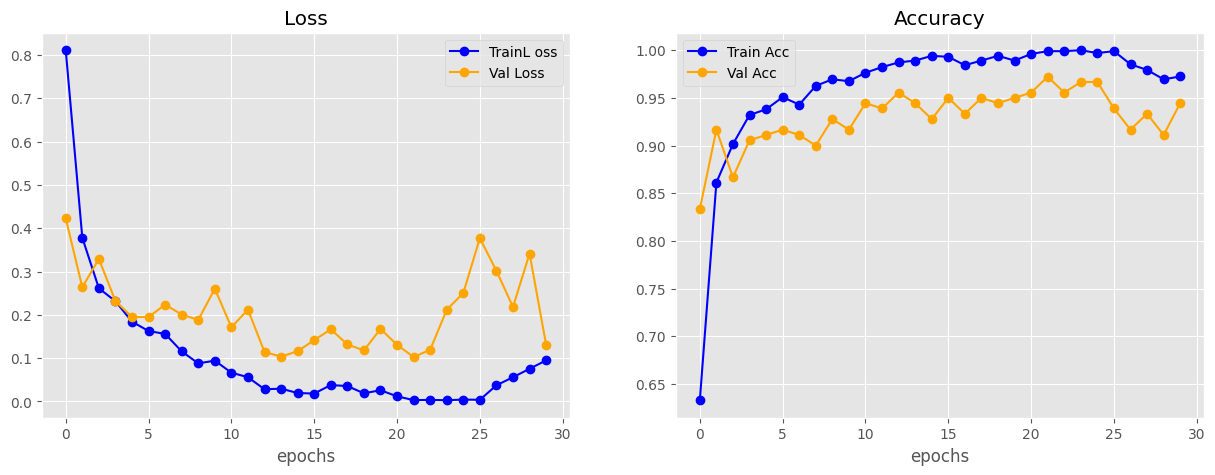

In [36]:
plot_curves(cnn_history)

In [38]:
cnn_predictions_probs = cnn_model.predict(test_data)

# Choosing highest probalbilty class in every prediction
cnn_predictions = np.argmax(cnn_predictions_probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step


[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

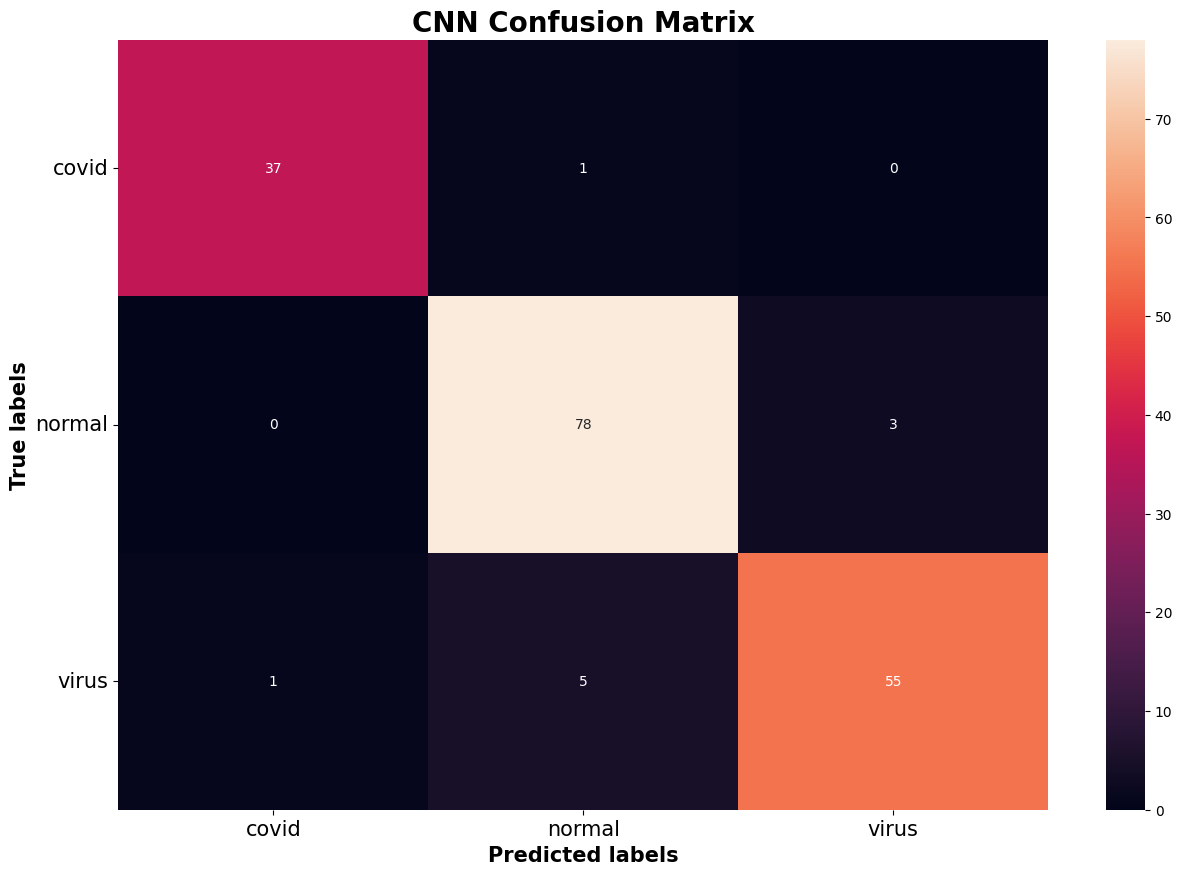

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, cnn_predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Classes , fontsize=15)
ax.set_yticklabels(Classes, rotation=0, fontsize=15)

In [40]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(test_data.labels, cnn_predictions, target_names= Classes)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       0.97      0.97      0.97        38
      normal       0.93      0.96      0.95        81
       virus       0.95      0.90      0.92        61

    accuracy                           0.94       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.94      0.94      0.94       180



In [41]:
from sklearn.metrics import accuracy_score

print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, cnn_predictions) * 100))

Test Accuracy: 94.44%


- **The Testing Accuracy after 30 Epochs was about 94.44%, Perhaps it would increase with more epochs but it will not be a huge increase.**

- **Transfer Learning will be useful, with more complex model architectures it will be able to achieve fit the data better.**

In [ ]:
import base64
import io
import numpy as np
import paho.mqtt.client as mqtt
import requests
from PIL import Image
import tensorflow as tf

# MQTT settings
MQTT_BROKER = "modelcnn.cloud.shiftr.io"
MQTT_PORT = 1883
MQTT_USERNAME = "UserName"
MQTT_PASSWORD = "PassWord"
MQTT_TOPIC_IMAGE = "patient/image"

# Initialize global variable for image data
image_data = None

# Function to load and preprocess the image
def preprocess_image(image):
    img = RadioPulmonaire.resize((224, 224))  # Assuming the model expects 224x224 images
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to connect to MQTT broker
def on_connect(client, userdata, flags, rc):
    print(f"Connected with result code {rc}")
    client.subscribe(MQTT_TOPIC_IMAGE)

# Function to handle incoming messages
def on_message(client, userdata, msg):
    global image_data
    
    # Decode the base64 image
    image_bytes = base64.b64decode(msg.payload)
    image = Image.open(io.BytesIO(image_bytes))
    
    # Preprocess the image
    image_data = preprocess_image(image)
    
    # If image data is available, make a prediction
    if image_data is not None:
        prediction = predict_cnn(image_data)
        print("Predicted result by CNN model:", prediction)

# Function to make a prediction using the CNN model
def predict_cnn(image):
    # Send a request to the CNN model server
    response = requests.post('https://modelcnn.cloud.shiftr.io/predict', files={'file': image})
    
    # Assuming the server returns a JSON response with the prediction
    if response.status_code == 200:
        return response.json().get('prediction')
    else:
        print("Failed to get a prediction from the model server")
        return None

# Initialize MQTT client
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

# Connect to MQTT broker
client.username_pw_set(MQTT_USERNAME, MQTT_PASSWORD)
client.connect(MQTT_BROKER, MQTT_PORT, 60)

# Example usage
if __name__ == "__main__":
    # Let the MQTT client run in the background
    client.loop_forever()
